
# Chapter 9 -> Spark ETL with Lakehouse | Apache Iceberg

Task to do 
1. Read data from MySQL server into Spark
2. Create HIVE temp view from data frame
3. Load filtered data into Iceberg format (create initial table)
4. Load filtered data again into Iceberg format into same table 
5. Read Iceberg tables using Spark data frame
6. Create Temp HIVE of delta tables
7. Write query to read data from delta 


In [1]:
# First Load all the required library and also Start Spark Session
# Load all the required library
from pyspark.sql import SparkSession

In [2]:
#Start Spark Session
spark = SparkSession.builder.appName("chapter8")\
        .config('spark.jars.packages', 'org.apache.iceberg:iceberg-spark-runtime-3.2_2.12:1.1.0,mysql:mysql-connector-java:8.0.32')\
        .config('spark.sql.extensions', 'org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions')\
        .config('spark.sql.catalog.spark_catalog', 'org.apache.iceberg.spark.SparkSessionCatalog')\
        .config('spark.sql.catalog.spark_catalog.type', 'hive')\
        .config('spark.sql.catalog.local', 'org.apache.iceberg.spark.SparkCatalog')\
        .config('spark.sql.catalog.local.type','hadoop')\
        .config('spark.sql.catalog.local.warehouse','warehouse')\
        .config('spark.sql.defaultCatalog','local')\
        .getOrCreate()

sqlContext = SparkSession(spark)
#Dont Show warning only error
spark.sparkContext.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.2_2.12 added as a dependency
mysql#mysql-connector-java added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2347fafb-bc66-49b9-bd5f-f90f1609557a;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.2_2.12;1.1.0 in central
	found mysql#mysql-connector-java;8.0.32 in central
	found com.mysql#mysql-connector-j;8.0.32 in central
	found com.google.protobuf#protobuf-java;3.21.9 in central
:: resolution report :: resolve 513ms :: artifacts dl 15ms
	:: modules in use:
	com.google.protobuf#protobuf-java;3.21.9 from central in [default]
	com.mysql#mysql-connector-j;8.0.32 from central in [default]
	mysql#mysql-connector-java;8.0.32 from central in [default]
	org.apache.iceberg#iceberg-spark-runtime-3.2_2.12;1.1.0 from central in [default]
	----------------------------------------------------------------

1. Read data from MySQL server into Spark

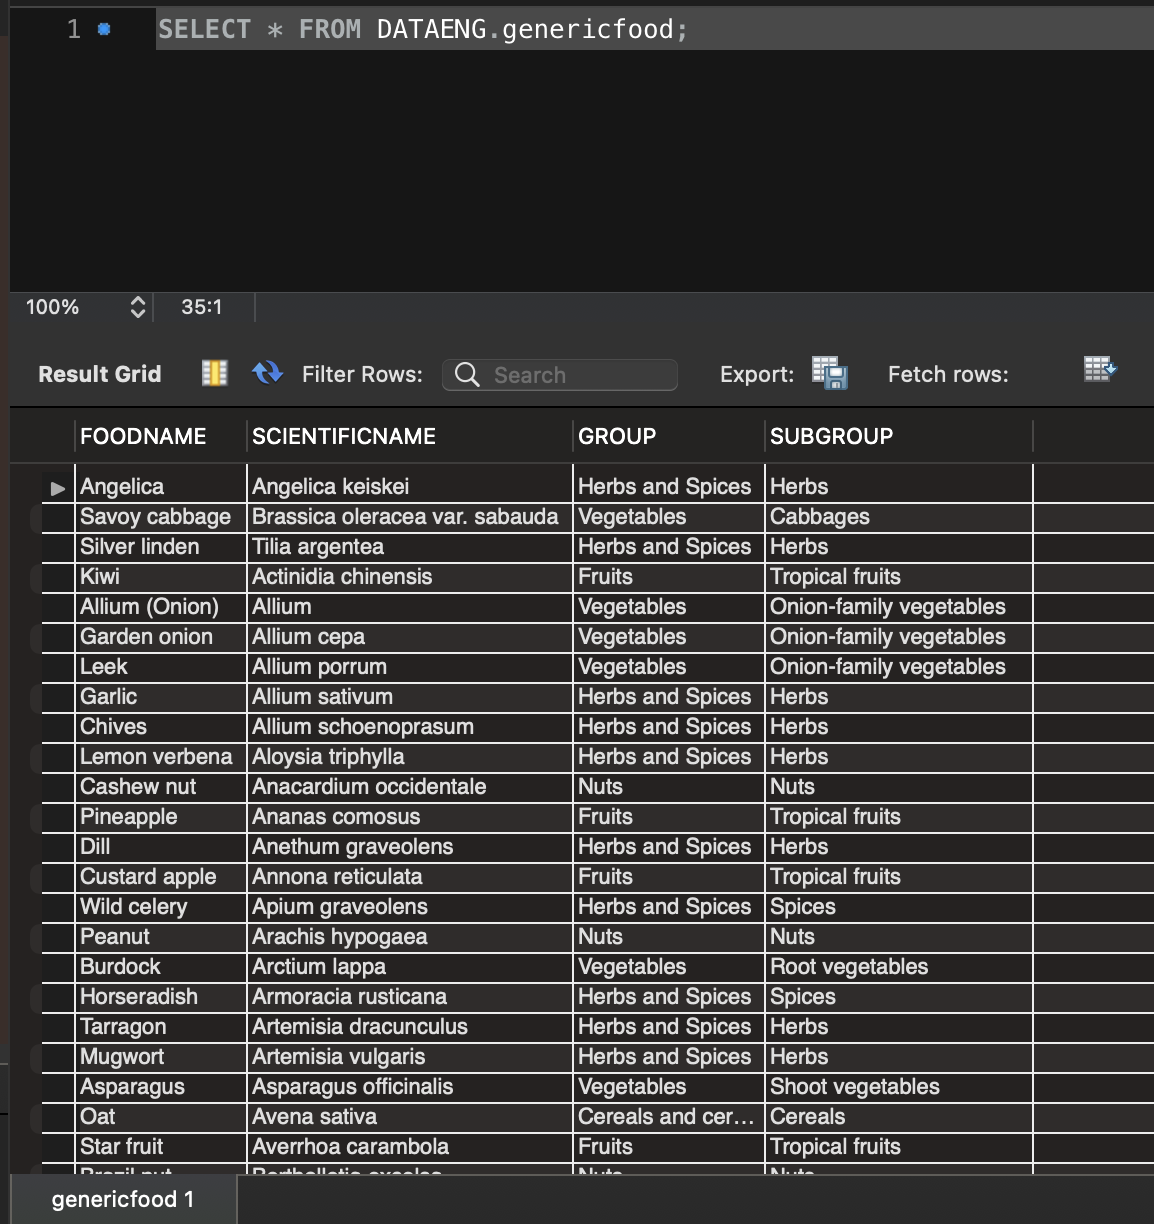


In [3]:
#Load CSV file into DataFrame
mysqldf = spark.read \
    .format("jdbc") \
    .option("driver","com.mysql.cj.jdbc.Driver") \
    .option("url", "jdbc:mysql://192.168.1.104:3306/DATAENG") \
    .option("dbtable", "genericfood") \
    .option("user", "root") \
    .option("password", "mysql") \
    .load()

In [4]:
#Checking dataframe schema
mysqldf.printSchema()

root
 |-- FOODNAME: string (nullable = true)
 |-- SCIENTIFICNAME: string (nullable = true)
 |-- GROUP: string (nullable = true)
 |-- SUBGROUP: string (nullable = true)



In [5]:
mysqldf.show(n=10)

+--------------+--------------------+----------------+--------------------+
|      FOODNAME|      SCIENTIFICNAME|           GROUP|            SUBGROUP|
+--------------+--------------------+----------------+--------------------+
|      Angelica|    Angelica keiskei|Herbs and Spices|               Herbs|
| Savoy cabbage|Brassica oleracea...|      Vegetables|            Cabbages|
| Silver linden|      Tilia argentea|Herbs and Spices|               Herbs|
|          Kiwi| Actinidia chinensis|          Fruits|     Tropical fruits|
|Allium (Onion)|              Allium|      Vegetables|Onion-family vege...|
|  Garden onion|         Allium cepa|      Vegetables|Onion-family vege...|
|          Leek|       Allium porrum|      Vegetables|Onion-family vege...|
|        Garlic|      Allium sativum|Herbs and Spices|               Herbs|
|        Chives|Allium schoenoprasum|Herbs and Spices|               Herbs|
| Lemon verbena|   Aloysia triphylla|Herbs and Spices|               Herbs|
+-----------

2. Create HIVE temp view from data frame

In [6]:
mysqldf.createOrReplaceTempView("tempFood")

3. Load filtered data into Iceberg format (create initial table)

In [7]:
sqlContext.sql("SELECT * FROM tempFood").show(n=20)

+--------------+--------------------+----------------+--------------------+
|      FOODNAME|      SCIENTIFICNAME|           GROUP|            SUBGROUP|
+--------------+--------------------+----------------+--------------------+
|      Angelica|    Angelica keiskei|Herbs and Spices|               Herbs|
| Savoy cabbage|Brassica oleracea...|      Vegetables|            Cabbages|
| Silver linden|      Tilia argentea|Herbs and Spices|               Herbs|
|          Kiwi| Actinidia chinensis|          Fruits|     Tropical fruits|
|Allium (Onion)|              Allium|      Vegetables|Onion-family vege...|
|  Garden onion|         Allium cepa|      Vegetables|Onion-family vege...|
|          Leek|       Allium porrum|      Vegetables|Onion-family vege...|
|        Garlic|      Allium sativum|Herbs and Spices|               Herbs|
|        Chives|Allium schoenoprasum|Herbs and Spices|               Herbs|
| Lemon verbena|   Aloysia triphylla|Herbs and Spices|               Herbs|
|    Cashew 

In [8]:
sqlContext.sql("SELECT GROUP,count(*) FROM tempFood GROUP BY 1 ORDER BY 2 DESC").show(truncate=False)

+---------------------------+--------+
|GROUP                      |count(1)|
+---------------------------+--------+
|Herbs and Spices           |52      |
|Fruits                     |43      |
|Vegetables                 |31      |
|Nuts                       |11      |
|Pulses                     |9       |
|Cereals and cereal products|6       |
|Gourds                     |5       |
|Coffee and coffee products |3       |
|Teas                       |1       |
|Soy                        |1       |
+---------------------------+--------+



In [9]:
newdf = sqlContext.sql("SELECT * FROM tempFood WHERE GROUP = 'Herbs and Spices'")

In [10]:
newdf.count()

52

In [11]:
newdf.writeTo("iceberg_food").using("iceberg").create()

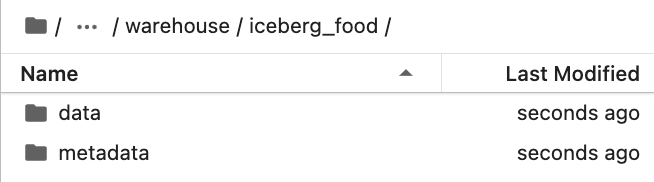

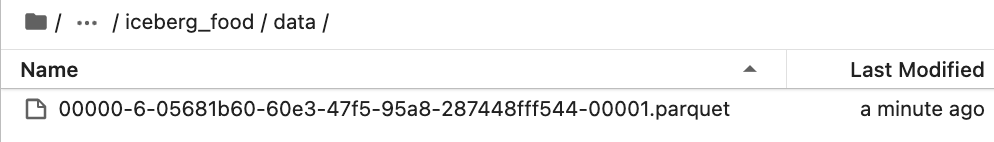

4. Load filtered data again into Iceberg format into same table 

In [12]:
newdf1 = sqlContext.sql("SELECT * FROM tempFood WHERE GROUP = 'Fruits'")

In [13]:
newdf1.write.format("iceberg").save("iceberg_food",mode='append')

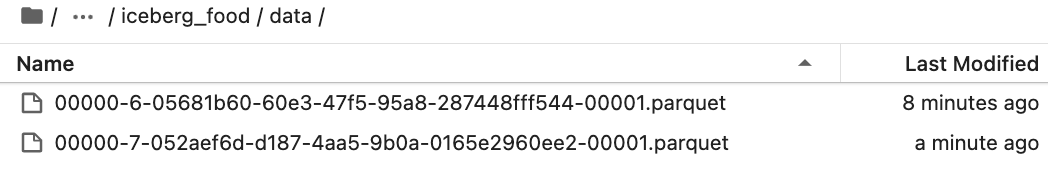

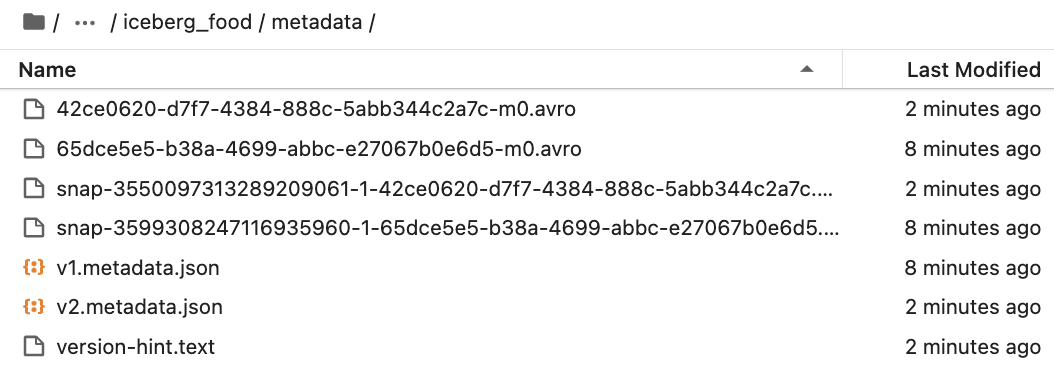

5. Read iceberg tables using Spark data frame

In [20]:
#Load delta file into DataFrame
icebergdf = spark.read.format("iceberg").load("iceberg_food")

In [21]:
icebergdf.printSchema()

root
 |-- FOODNAME: string (nullable = true)
 |-- SCIENTIFICNAME: string (nullable = true)
 |-- GROUP: string (nullable = true)
 |-- SUBGROUP: string (nullable = true)



In [22]:
icebergdf.show()

+----------------+--------------------+----------------+-------------+
|        FOODNAME|      SCIENTIFICNAME|           GROUP|     SUBGROUP|
+----------------+--------------------+----------------+-------------+
|        Angelica|    Angelica keiskei|Herbs and Spices|        Herbs|
|   Silver linden|      Tilia argentea|Herbs and Spices|        Herbs|
|          Garlic|      Allium sativum|Herbs and Spices|        Herbs|
|          Chives|Allium schoenoprasum|Herbs and Spices|        Herbs|
|   Lemon verbena|   Aloysia triphylla|Herbs and Spices|        Herbs|
|            Dill|  Anethum graveolens|Herbs and Spices|        Herbs|
|     Wild celery|    Apium graveolens|Herbs and Spices|       Spices|
|     Horseradish| Armoracia rusticana|Herbs and Spices|       Spices|
|        Tarragon|Artemisia dracunc...|Herbs and Spices|        Herbs|
|         Mugwort|  Artemisia vulgaris|Herbs and Spices|        Herbs|
|          Borage|  Borago officinalis|Herbs and Spices|Oilseed crops|
|     

6. Create Temp HIVE of iceberg tables

In [23]:
icebergdf.createOrReplaceTempView("tempIceberg")

7. Write query to read data from iceberg

In [24]:
sqlContext.sql("SELECT * FROM tempIceberg").show()

+--------------------+--------------------+------+---------------+
|            FOODNAME|      SCIENTIFICNAME| GROUP|       SUBGROUP|
+--------------------+--------------------+------+---------------+
|                Kiwi| Actinidia chinensis|Fruits|Tropical fruits|
|           Pineapple|      Ananas comosus|Fruits|Tropical fruits|
|       Custard apple|   Annona reticulata|Fruits|Tropical fruits|
|          Star fruit|  Averrhoa carambola|Fruits|Tropical fruits|
|              Papaya|       Carica papaya|Fruits|Tropical fruits|
|                Lime|Citrus aurantiifolia|Fruits|         Citrus|
|               Lemon|        Citrus limon|Fruits|         Citrus|
|             Pummelo|       Citrus maxima|Fruits|         Citrus|
|Mandarin orange (...|   Citrus reticulata|Fruits|         Citrus|
|        Sweet orange|     Citrus sinensis|Fruits|         Citrus|
|              Quince|     Cydonia oblonga|Fruits|          Pomes|
|  Japanese persimmon|      Diospyros kaki|Fruits|Tropical fru

In [25]:
sqlContext.sql("SELECT count(*) FROM tempIceberg").show()

+--------+
|count(1)|
+--------+
|      95|
+--------+



In [26]:
sqlContext.sql("SELECT DISTINCT(SUBGROUP) FROM tempIceberg").show()

+---------------+
|       SUBGROUP|
+---------------+
|Tropical fruits|
|         Citrus|
|          Pomes|
|        Berries|
|   Other fruits|
|         Drupes|
|          Herbs|
|         Spices|
|  Oilseed crops|
+---------------+



In [27]:
sqlContext.sql("SELECT SUBGROUP,count(*) FROM tempIceberg GROUP BY SUBGROUP ORDER BY 2 DESC ").show()

+---------------+--------+
|       SUBGROUP|count(1)|
+---------------+--------+
|          Herbs|      33|
|        Berries|      13|
|Tropical fruits|      13|
|         Spices|      13|
|  Oilseed crops|       6|
|         Drupes|       6|
|         Citrus|       5|
|          Pomes|       4|
|   Other fruits|       2|
+---------------+--------+

